# Test case $\ce{LiFePO4}$

In this section, the existing data of $\ce{LiFePO4}$ search and check if the low energy structures can be find by relaxation using M3GNet.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

import warnings
from pathlib import Path
from ase.io import read
import ase
# from m3gnet.models import Relaxer
# from pymatgen.ext.matproj import MPRester

import pandas as pd
from tqdm import tqdm
tqdm = lambda x: x


from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure

In [2]:
# Load pre-computed relaxation results
lfp_mp = Structure.from_file("LiFePO4-mp-19017.vasp")
lfp_cmcm = Structure.from_file("LiFePO4-mp-18951.vasp")

Load pre-computed results

In [3]:
lfp_relaxed = read("exp-m3gnet/LiFePO4-mp-19017.res")
lfp_relaxed_energy = lfp_relaxed.info['energy'] / len(lfp_relaxed)
lfp_relaxed_volume = lfp_relaxed.get_volume() / len(lfp_relaxed)

lfp_cmcm_relaxed = read("exp-m3gnet/LiFePO4-mp-18951.res")
lfp_cmcm_relaxed_energy = lfp_cmcm_relaxed.info['energy'] / len(lfp_cmcm_relaxed)
lfp_cmcm_relaxed_volume = lfp_cmcm_relaxed.get_volume()/ len(lfp_cmcm_relaxed)

In [4]:
def load_dataset(names):
    """Load dataset"""
    cells = [read(x) for x in  tqdm(names)]
    for atoms, name in zip(cells, input_names):
        atoms.info['fname'] = name.stem

    dataset = []
    for atoms in cells:
        dataset.append(
        {
            'atoms': atoms,
            'label': atoms.info['fname'],
            'energy': atoms.info['energy'],
            'energy_per_atom': atoms.info['energy'] / len(atoms),
            'volume': atoms.get_volume(),
            'volume_per_atom': atoms.get_volume() / len(atoms),

        }
        )

    return pd.DataFrame(dataset).sort_values('energy_per_atom')

def show_compact(df):
    return df[['label', 'energy_per_atom', 'volume_per_atom']]

Load calculated data:

In [5]:
# AIRSS Search with CASTEP QC5
input_names = list(Path("with-u-rerun").glob("*.res"))
df_dft = load_dataset(input_names)

# AIRSS Search with structures relaxed buy M3GNet
input_names = list(Path("with-u-rerun-m3gnet").glob("*.res"))
df_m3g = load_dataset(input_names)

# AIRSS Search with structures relaxed buy M3GNet
input_names = list(Path("with-u-rerun-relaxed-m3gnet").glob("*.res"))
df_relaxed_m3g = load_dataset(input_names)

# AIRSS Search results recalculated using VASP PBE + U
input_names = list(Path("with-u-rerun-refine").glob("*.res"))
df_dft_refine = load_dataset(input_names)

# Extra AIRSS search (new structure from buildcell) relaxed with M3GNet focusing on four formula units
input_names = list(Path("with-u-rerun-extras-m3gnet/").glob("*.res"))
df_m3g_extras = load_dataset(input_names)

## Energy - Volume distribution

Here, we plot the energy per atom against the volume per atom.
Such plots are useful for checking the search results and how the relaxed structure distribute in the configuration space. 
Very often the unique structure can be identified this way, as different polymorphs tend to have different volumes

The input structures relaxed by M3GNet are those used in the previous search. 
Experimental structures as labelled with diamond and they are also relaxed using M3GNet.
There are two experimental structures, $Pnma$ (olivine) and $Cmcm$ (high-temperature / pressure phase).
The orange dots represent the structure that are first relaxed by DFT, then re-relaxed by M3GNet.

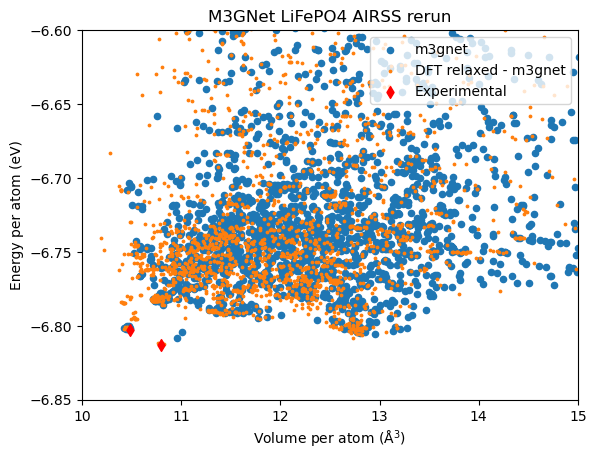

In [6]:
def add_labels(ax):
    """Add axis labels"""
    ax.set_ylabel('Energy per atom (eV)')
    ax.set_xlabel(r'Volume per atom ($\mathrm{\AA^3}$)')

ax = df_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='m3gnet')
ax = df_relaxed_m3g.plot.scatter('volume_per_atom', 'energy_per_atom', label='DFT relaxed - m3gnet', color='C1', ax=ax,s=3)

ax.scatter( [lfp_relaxed_volume, lfp_cmcm_relaxed_volume], [lfp_relaxed_energy, lfp_cmcm_relaxed_energy],  marker='d', color='r', label='Experimental')
ax.set_xlim(10, 15)
ax.set_ylim(-6.85, -6.6)
ax.legend(loc=1)
ax.set_title('M3GNet LiFePO4 AIRSS rerun')
add_labels(ax)

It appears that the M3GNet search is capable of finding the $Cmcm$ structure. 
But for the $Pnma$ phase it is not so clear. 
There are two structure that can be the $Pnma$ structure (close to the lowest energy diamond) upon inspection.
However, they are not identical to the actual $Pnma$ structure after relaxation.
Interestingly, relaxing the $Pnma$ structure from the DFT search gives the same result as starting from the experimental $Pnma$.
This confirms that the former is indeed the ground state structure.

One possible explanation of such strange behaviour is that relaxation is stuck due to a noisy potential energy surface.

The top three structures in the DFT search are the $Pnma$ structure are tabulated below:

In [7]:
show_compact(df_dft.iloc[:3])

,label,energy_per_atom,volume_per_atom
2318,4LFP_actual-201127-012020-107264,-433.948175,10.498721
1811,4LFP_actual-201126-142402-eb7dce,-433.945196,10.428370
1821,4LFP_actual-201126-144638-9aee88,-433.940921,10.493866


The table below shows the top three structures in the M3GNet search.
The first structure is in fact very close to the $Pnma$ structure.
The second and the third structure has much larger volume, however, which are potentially from an false minimum.

In [8]:
show_compact(df_m3g.iloc[:3])

,label,energy_per_atom,volume_per_atom
1821,4LFP_actual-201126-144638-9aee88,-6.808464,10.955443
2023,4LFP_actual-201126-194829-b3779f,-6.805621,12.959209
1307,4LFP-201124-120454-c024e6,-6.804693,12.802004


Top three entries in the M3GNet-relaxed-DFT-optimised structure, note that they are the same as the top three in the DFT dataset above.

In [9]:
show_compact(df_relaxed_m3g.iloc[:3])

,label,energy_per_atom,volume_per_atom
1821,4LFP_actual-201126-144638-9aee88,-6.812143,10.830344
2318,4LFP_actual-201127-012020-107264,-6.811954,10.808982
1811,4LFP_actual-201126-142402-eb7dce,-6.811675,10.769253


Due to the low cost of M3GNet relaxation, we can afford to sample much more structures than DFT, even if the latter already uses low-cost setting focusing on the speed.
But this time the $Pnma$ structure is not found, maybe it is just bad luck? The search includes random structures containing 4 formula units only. 

:::{dropdown} Search settings for random structure generation
```

%BLOCK LATTICE_CART
10.452988  0.000000  0.000000
 0.000000  6.086495  0.000000
 0.000000  0.000000  4.753437
%ENDBLOCK LATTICE_CART

#TARGVOL=80

%BLOCK POSITIONS_ABS
Li  0.000000  0.000000  0.000000
O  4.217576  4.564871  5.905294 #  PO4-1 %  
O  3.494553  3.329881  3.736885 #  PO4-1 %
O  3.494553  5.799862  3.736885 #  PO4-1 % 
O  5.672957  4.564871  3.771439 #  PO4-1 % 
P  4.236933  4.564871  4.367667  #  PO4-1 % 
Fe  8.168949  1.521624  2.490639 
%ENDBLOCK POSITIONS_ABS

#SYMMOPS=2-4
###SGRANK=20
#NFORM=4
#SLACK=0.25
#OVERLAP=0.1
#COMPACT
#CELLADAPT
#MINSEP=1.0 Li-Li=3.04 Li-O=2.11 Li-P=2.69 Li-Fe=3.31 O-O=2.47 O-P=1.54 O-Fe=2.10 P-P=3.71 P-Fe=2.87 Fe-Fe=3.92
#ADJGEN=0-1
#SPIN=4 4 Fe

KPOINTS_MP_SPACING 0.07
 
SYMMETRY_GENERATE
SNAP_TO_SYMMETRY
 
%BLOCK SPECIES_POT
QC5
%ENDBLOCK SPECIES_POT
 
%BLOCK EXTERNAL_PRESSURE
0 0 0
0 0
0
%ENDBLOCK EXTERNAL_PRESSURE
```
:::

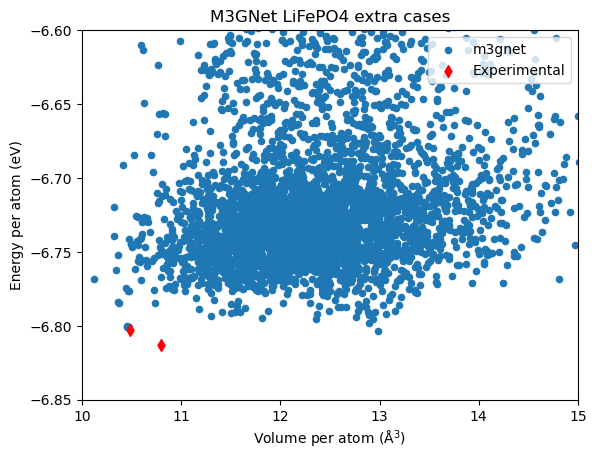

In [10]:
ax = df_m3g_extras.plot.scatter('volume_per_atom', 'energy_per_atom', label='m3gnet')

ax.scatter( [lfp_relaxed_volume, lfp_cmcm_relaxed_volume], [lfp_relaxed_energy, lfp_cmcm_relaxed_energy],  marker='d', color='r', label='Experimental')
ax.set_xlim(10, 15)
ax.set_ylim(-6.85, -6.6)
ax.legend(loc=1)
ax.set_title('M3GNet LiFePO4 extra cases')
add_labels(ax)

The top structure has an increased volume this time.

In [11]:
show_compact(df_m3g_extras.iloc[:4])

,label,energy_per_atom,volume_per_atom
1938,4LFP-extras-2879,-6.803350,12.987641
2725,4LFP-extras-3721,-6.801261,10.452332
1848,4LFP-extras-2798,-6.801075,10.475961
1187,4LFP-extras-2148,-6.800354,10.459634


Results of the DFT PBE + U search using CASTEP with the QC5 pseudopotential is shown below.

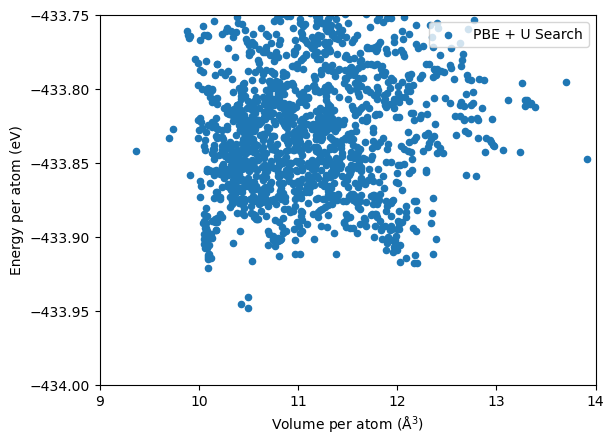

In [12]:
ax = df_dft.plot.scatter('volume_per_atom', 'energy_per_atom', xlim=(9, 14), ylim=(-434, -433.75), label='PBE + U Search')
ax.legend(loc=1)
add_labels(ax)

Both the $Pnma$ and the $Cmcm$ phases have been found. 
The DFT energies have large spreads due to the coarse calculation settings used. As we show above, the top three lowest energy structures are indeed the $Pnma$ phase.


Below is a plot for the structures from the AIRSS search, but re-relaxed using VASP PBE + U.
The settings used the different from those in the Materials Project (used for M3GNet training) hence the energies are not comparable.

Nevertheless, the low energy $Pnma$ and $Cmcm$ phases can be identified.

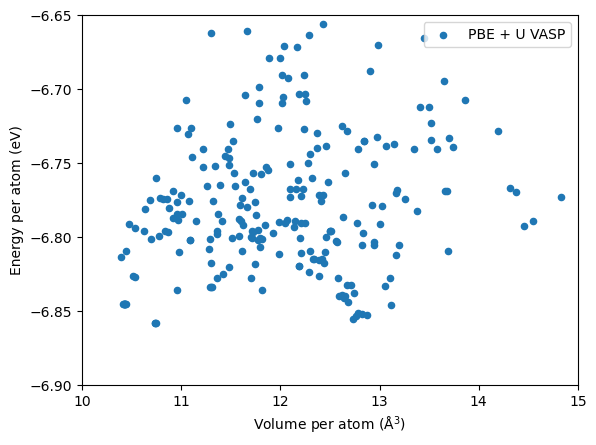

In [13]:
ax = df_dft_refine.plot.scatter('volume_per_atom', 'energy_per_atom', label='PBE + U VASP')
ax.legend(loc=1)
ax.set_xlim(10, 15)
ax.set_ylim(-6.90, -6.65)
add_labels(ax)

## Energy distribution of the relaxed structures

In this section, we compare the distributions of the energy in the relaxed structures. 
This gives some hint of distribution of the local minima in the potential energy surface.
Very different distributions mean the potential energy surfaces are very different.

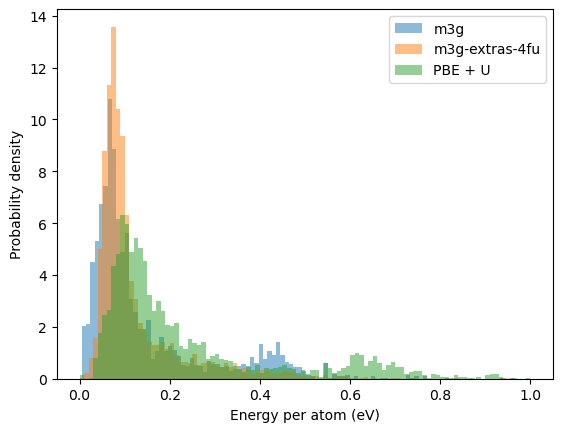

In [14]:
import matplotlib.pyplot as plt

engs = df_m3g['energy_per_atom'].values.copy()
engs_m3g = engs - lfp_relaxed_energy
engs = df_m3g_extras['energy_per_atom'].values.copy()
engs_m3g_extras = engs - lfp_relaxed_energy

engs = df_dft['energy_per_atom'].values.copy()
engs_dft = engs - engs.min()

plt.hist(engs_m3g, bins=100,alpha=0.5,density=True, label='m3g');
plt.hist(engs_m3g_extras, range=(0,1), bins=100,alpha=0.5,density=True, label='m3g-extras-4fu');

plt.hist(engs_dft, bins=100, range=(0,1), alpha=0.5, density=True, label='PBE + U')
plt.legend()
plt.xlabel('Energy per atom (eV)')
plt.ylabel('Probability density');

The two distributions, one from the DFT search and the other from M3GNet, do not differ much, 
indicating the M3GNet has done a good job here reproducing the energy landscape of the DFT.


## Discussion

For $\ce{LiFePO4}$ M3GNet is capable of locating the low energy $Cmcm$ phase as well as the $Pnma$ phase, 
although there seems to be some complication with the latter, 
but it is very likely the true DFT ground state can be recovered after further DFT relaxation.

So can we use M3GNet for searching? Probably fine for $\ce{LiFePO4}$, but are something one should note:

- M3GNet appears to generate some false minima, which is unlikely to happen for DFT calculation despite the use of coarse settings.

- On the other hand, M3GNet has much reduced calculation costs hence much more structures may be sampled. The true ground state can still be recovered even if there are false minima. 

- One should note that M3GNet is built from a vast database of DFT calculations which already contains the target structures,
  while a DFT search does not rely on any pre-existing data apart from some estimate specie-wise distances. 

- The Materials Project contains many data for oxide and phosphates, in addition it also has relative large set of data for $\ce{LiFePO4}$ polymorphs.

Hence, further tests are need to answer if M3GNet work well where the ground state is not included in the training set.